Read CSV data with Pandas.

In [1]:
import pandas as pd
import numpy as np

# team stats
team_summaries = pd.read_csv('nba_data/stats_archive/Team Summaries.csv')
# team_totals = pd.read_csv('nba_data/stats_archive/Team Totals.csv')
team_per100 = pd.read_csv('nba_data/stats_archive/Team Stats Per 100 Poss.csv')

# player stats
# player_totals = pd.read_csv('nba_data/stats_archive/Player Totals.csv')
player_shooting = pd.read_csv('nba_data/stats_archive/Player Shooting.csv')
player_play_by_play = pd.read_csv('nba_data/stats_archive/Player Play By Play.csv')
player_per100 = pd.read_csv('nba_data/stats_archive/Per 100 Poss.csv')

# games
games = pd.read_csv('nba_data/game_archive/games.csv')
teamids = pd.read_csv('nba_data/game_archive/teams.csv')


Remove unnecessary features.

In [2]:
# games
teamids['TEAM_NAME'] = teamids['CITY'] + ' ' + teamids['NICKNAME']
teamids = teamids[['TEAM_ID','TEAM_NAME','ABBREVIATION']]

games = games[['GAME_DATE_EST','GAME_ID','HOME_TEAM_ID','VISITOR_TEAM_ID','SEASON','HOME_TEAM_WINS','PTS_home','PTS_away']]

In [3]:
# team stats
team_stats = team_summaries.merge(team_per100)
team_stats.drop(columns=['playoffs','arena','attend','lg'], inplace=True)

# player stats
player_stats = player_shooting.merge(player_play_by_play).merge(player_per100)
player_stats.drop(columns=['birth_year','pos','lg'], inplace=True)

Create player efficiency indices.

𝐼NBA=𝑁pts+𝑁rbs+𝑁asts+𝑁stls+𝑁blcks−(𝑁msFld+𝑁msFT+𝑁tos)

In [4]:
player_stats['player_eff_ind'] = (player_stats['pts_per_100_poss'] +
                           player_stats['trb_per_100_poss'] +
                           player_stats['ast_per_100_poss'] +
                           player_stats['stl_per_100_poss'] +
                           player_stats['blk_per_100_poss'] -
                           (player_stats['tov_per_100_poss'] +
                            player_stats['fga_per_100_poss'] - player_stats['fg_per_100_poss'] +
                            player_stats['fta_per_100_poss'] - player_stats['ft_per_100_poss']))
# player_stats

Create team efficiency indices.

In [5]:
#create the team efficeny index by summing the players by season and team 
team_eff_ind = player_stats.groupby(['tm', 'season'])['player_eff_ind'].sum().reset_index(name='team_eff_ind')
team_eff_ind.rename(columns = {'tm':'abbreviation'}, inplace = True)

In [6]:
#merging the team efficeny index to team_stats
team_stats = team_stats.merge(team_eff_ind)
# team_stats

In [7]:
team_stats['next_season'] = team_stats['season'] + 1

To each game, append home and away team stats in the respective season.

In [8]:
# add team_id to team stats
teamids.rename(columns = {'ABBREVIATION':'abbreviation','TEAM_NAME':'team'}, inplace = True)
team_stats = team_stats.merge(teamids)
team_stats.drop(columns=['team','abbreviation'], inplace = True)

In [9]:
min(team_stats.season)

1997

In [10]:
# # add home team stats to games
# h_team_stats = team_stats.add_prefix('h_')
# final_df = games.merge(h_team_stats, left_on=['HOME_TEAM_ID','SEASON'], right_on=['h_TEAM_ID','h_season'])
# final_df.drop(columns=['h_season','h_TEAM_ID'], inplace = True)

# # add away team stats to games
# a_team_stats = team_stats.add_prefix('a_')
# final_df = final_df.merge(a_team_stats, left_on=['VISITOR_TEAM_ID','SEASON'], right_on=['a_TEAM_ID','a_season'])
# final_df.drop(columns=['a_season','a_TEAM_ID'], inplace = True)

# add home team stats to games
h_team_stats = team_stats.add_prefix('h_')
final_df = games.merge(h_team_stats, left_on=['HOME_TEAM_ID','SEASON'], right_on=['h_TEAM_ID','h_next_season'])
final_df.drop(columns=['h_season','h_next_season','h_TEAM_ID'], inplace = True)

# add away team stats to games
a_team_stats = team_stats.add_prefix('a_')
final_df = final_df.merge(a_team_stats, left_on=['VISITOR_TEAM_ID','SEASON'], right_on=['a_TEAM_ID','a_next_season'])
final_df.drop(columns=['a_season','a_next_season','a_TEAM_ID'], inplace = True)

In [11]:
# sort games by date, ascending
final_df['GAME_DATE_EST'] = pd.to_datetime(final_df['GAME_DATE_EST'])
final_df = final_df.sort_values(by='GAME_DATE_EST', ascending=True).reset_index(drop=True)

Add novel features from the parent paper.

In [12]:
import warnings
warnings.filterwarnings("ignore")

final_df = final_df[final_df['HOME_TEAM_WINS'].notna()]

def get_avg_win_pct_last_n_games(team, game_date, df, n):
    # Extract the last 10 games 
    prev_game_df = df[df['GAME_DATE_EST'] < game_date][(df['HOME_TEAM_ID'] == team) | (df['VISITOR_TEAM_ID'] == team)].tail(n)
    
    wins = 0 
    # Filter columns to include only 'Home' team and result, then divide into home and away games        
    result_df = prev_game_df
    h_df = result_df.loc[result_df['HOME_TEAM_ID'] == team] 
    
    h_wins = h_df.loc[h_df['HOME_TEAM_WINS'] == 1]
    
    wins += len(h_wins)
    
    a_df = result_df.loc[result_df['HOME_TEAM_ID'] != team]
    a_wins = a_df.loc[a_df['HOME_TEAM_WINS'] == 0]
    
    wins += len(a_wins)

    return wins/n

for index, row in final_df.iterrows() : 
    game_id = row['GAME_ID']
    game_date = row['GAME_DATE_EST']
    h_team = row['HOME_TEAM_ID']
    a_team = row['VISITOR_TEAM_ID']
    final_df.loc[index,'H_w_pct_10'] = get_avg_win_pct_last_n_games(h_team, game_date, final_df, 10)
    final_df.loc[index,'A_w_pct_10'] = get_avg_win_pct_last_n_games(a_team, game_date, final_df, 10)

In [13]:
# Home and road team win probabilities implied by Elo ratings and home court adjustment 
import math
# import time

final_df = final_df[final_df['PTS_away'].notna() & final_df['PTS_home'].notna()]

# Calculate win probabilities using Elo ratings and home court advantage
def win_probs(home_elo, away_elo, home_court_advantage) :
    h = math.pow(10, home_elo/400)
    r = math.pow(10, away_elo/400)
    a = math.pow(10, home_court_advantage/400) 

    denom = r + a*h
    home_prob = a*h / denom
    away_prob = r / denom 
  
    return home_prob, away_prob

# Calculate odds of the home team winning based on Elo ratings and home court advantage
def home_odds_on(home_elo, away_elo, home_court_advantage) :
    h = math.pow(10, home_elo/400)
    r = math.pow(10, away_elo/400)
    a = math.pow(10, home_court_advantage/400)
    return a*h/r

# Determines the K factor in Elo rating updates, considering the margin of victory and Elo rating difference
def elo_k(MOV, elo_diff):
    k = 20
    if MOV>0:
        multiplier=(MOV+3)**(0.8)/(7.5+0.006*(elo_diff))
    else:
        multiplier=(-MOV+3)**(0.8)/(7.5+0.006*(-elo_diff))
    return k*multiplier

# Update Elo ratings for both teams following a game, considering the outcome and game specifics
def update_elo(home_score, away_score, home_elo, away_elo, home_court_advantage) :
    home_prob, away_prob = win_probs(home_elo, away_elo, home_court_advantage) 

    if (home_score - away_score > 0) :
        home_win = 1 
        away_win = 0 
    else :
        home_win = 0 
        away_win = 1 
  
    k = elo_k(home_score - away_score, home_elo - away_elo)

    updated_home_elo = home_elo + k * (home_win - home_prob) 
    updated_away_elo = away_elo + k * (away_win - away_prob)
    
    return updated_home_elo, updated_away_elo

# Define a function to retrieve a team's Elo rating before a given game, adjusting for season transitions
def get_prev_elo(team, date, season, team_stats, elo_df) :
    prev_game = team_stats[team_stats['GAME_DATE_EST'] < date][(team_stats['HOME_TEAM_ID'] == team) | (team_stats['VISITOR_TEAM_ID'] == team)].tail(1).iloc[0] 

    if team == prev_game['HOME_TEAM_ID'] :
        elo_rating = elo_df[elo_df['GAME_ID'] == prev_game['GAME_ID']]['H_Team_Elo_After'].values[0]
    else :
        elo_rating = elo_df[elo_df['GAME_ID'] == prev_game['GAME_ID']]['A_Team_Elo_After'].values[0]
  
    if prev_game['SEASON'] != season :
        return (0.75 * elo_rating) + (0.25 * 1505)
    else :
        return elo_rating

# create elo feature
elo_df = pd.DataFrame(columns=['GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'H_Team_Elo_Before', 'A_Team_Elo_Before', 'H_Team_Elo_After', 'A_Team_Elo_After'])
teams_elo_df = pd.DataFrame(columns=['GAME_ID','Team', 'Elo', 'GAME_DATE_EST', 'Where_Played', 'SEASON'])

# create elo feature
elo_df = pd.DataFrame(columns=['GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'H_Team_Elo_Before', 'A_Team_Elo_Before', 'H_Team_Elo_After', 'A_Team_Elo_After'])
teams_elo_df = pd.DataFrame(columns=['GAME_ID','Team', 'Elo', 'GAME_DATE_EST', 'Where_Played', 'SEASON'])

# Loop through each game to update ELO ratings
for index, row in final_df.iterrows(): 
    game_id = row['GAME_ID']
    game_date = row['GAME_DATE_EST']
    season = row['SEASON']
    h_team, a_team = row['HOME_TEAM_ID'], row['VISITOR_TEAM_ID']
    h_score, a_score = row['PTS_home'], row['PTS_away'] 
    # Set or get previous Elo ratings
    if (h_team not in elo_df['HOME_TEAM_ID'].values and h_team not in elo_df['VISITOR_TEAM_ID'].values) :
        h_team_elo_before = 1500
    else :
        h_team_elo_before = get_prev_elo(h_team, game_date, season, final_df, elo_df)

    if (a_team not in elo_df['HOME_TEAM_ID'].values and a_team not in elo_df['VISITOR_TEAM_ID'].values) :
        a_team_elo_before = 1500
    else :
        a_team_elo_before = get_prev_elo(a_team, game_date, season, final_df, elo_df)

    h_team_elo_after, a_team_elo_after = update_elo(h_score, a_score, h_team_elo_before, a_team_elo_before, 69)

    new_row = {'GAME_ID': game_id, 'HOME_TEAM_ID': h_team, 'VISITOR_TEAM_ID': a_team, 'H_Team_Elo_Before': h_team_elo_before, 'A_Team_Elo_Before': a_team_elo_before, \
                                                                        'H_Team_Elo_After' : h_team_elo_after, 'A_Team_Elo_After': a_team_elo_after}
    teams_row_one = {'GAME_ID': game_id,'Team': h_team, 'Elo': h_team_elo_before, 'GAME_DATE_EST': game_date, 'Where_Played': 'HOME_TEAM_ID', 'SEASON': season}
    teams_row_two = {'GAME_ID': game_id,'Team': a_team, 'Elo': a_team_elo_before, 'GAME_DATE_EST': game_date, 'Where_Played': 'VISITOR_TEAM_ID', 'SEASON': season}
    
    # Record Elo ratings in elo_df and teams_elo_df
    elo_df.loc[len(elo_df)] = new_row
    teams_elo_df.loc[len(teams_elo_df)] = teams_row_one
    teams_elo_df.loc[len(teams_elo_df)] = teams_row_two

teams_elo_df['Elo'] = teams_elo_df['Elo'].astype(float)
# Merge updated Elo ratings back into the main DataFrame
final_df = final_df.merge(elo_df.drop(columns=['HOME_TEAM_ID', 'VISITOR_TEAM_ID']), on ='GAME_ID')

In [14]:
# final_df.tail(20)

In [15]:
# # save final df, game season and stats season align
# final_df.to_csv(r'nba_data\our_df_final.csv', index = False)

# save final df, game season and stats previous season align
final_df.to_csv(r'nba_data\our_df_final2.csv', index = False)

In [18]:
import pandas as pd

# # load final df, game season and stats season align
# final_df = pd.read_csv('nba_data/our_df_final.csv')

# load final df, game season and stats previous season align
final_df = pd.read_csv('nba_data/our_df_final2.csv')

Reduce size of dataset to that of parent paper.

In [19]:
final_df = final_df[(final_df['SEASON'] >= 2018) & (final_df['SEASON'] <= 2021)]
final_df

,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,HOME_TEAM_WINS,PTS_home,PTS_away,h_age,h_w,...,a_tov_per_100_poss,a_pf_per_100_poss,a_pts_per_100_poss,a_team_eff_ind,H_w_pct_10,A_w_pct_10,H_Team_Elo_Before,A_Team_Elo_Before,H_Team_Elo_After,A_Team_Elo_After
15364,2018-09-29,11800005,1610612744,1610612750,2018,0,110.0,114.0,28.2,67.0,...,14.7,21.1,110.8,341.1,0.7,0.4,1662.716899,1528.927398,1651.913876,1539.730421
15365,2018-09-29,11800003,1610612761,1610612757,2018,1,122.0,104.0,26.1,51.0,...,14.0,21.6,110.3,345.3,0.4,0.2,1551.964593,1544.538965,1563.827370,1532.676187
15366,2018-09-30,11800010,1610612747,1610612743,2018,0,107.0,124.0,25.1,26.0,...,15.2,19.4,113.2,491.3,0.3,0.7,1482.119000,1548.236044,1468.091930,1562.263114
15367,2018-09-30,11800007,1610612759,1610612748,2018,1,104.0,100.0,29.6,61.0,...,14.0,21.4,107.8,327.2,0.3,0.4,1519.726487,1490.829154,1524.210871,1486.344769
15368,2018-09-30,11800009,1610612741,1610612740,2018,1,128.0,116.0,26.9,41.0,...,13.0,18.3,105.2,551.0,0.2,0.6,1381.975856,1546.344789,1398.961841,1529.358804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19643,2022-06-05,42100402,1610612744,1610612738,2021,1,107.0,88.0,24.4,15.0,...,13.8,21.5,113.3,436.6,0.7,0.7,1650.617650,1740.568987,1668.677357,1722.509280
19644,2022-06-08,42100403,1610612738,1610612744,2021,1,116.0,100.0,25.3,48.0,...,14.7,19.8,105.2,490.8,0.6,0.7,1722.509280,1668.677357,1731.411457,1659.775181
19645,2022-06-10,42100404,1610612738,1610612744,2021,0,97.0,107.0,25.3,48.0,...,14.7,19.8,105.2,490.8,0.6,0.6,1731.411457,1659.775181,1716.175454,1675.011183
19646,2022-06-13,42100405,1610612744,1610612738,2021,1,104.0,94.0,24.4,15.0,...,13.8,21.5,113.3,436.6,0.7,0.6,1675.011183,1716.175454,1684.884183,1706.302454


Prepare data for feature reduction and machine learning.

In [20]:
X = final_df.drop(columns=['GAME_DATE_EST',
 'GAME_ID',
 'HOME_TEAM_ID',
 'VISITOR_TEAM_ID',
 'SEASON',
 'HOME_TEAM_WINS',
 'H_Team_Elo_After',
 'A_Team_Elo_After'])

X = X.fillna(X.mean())
y = final_df['HOME_TEAM_WINS']

# X.head()

Exploratory data analysis.

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

def eda(df):
    plt.figure(figsize=(25, 25))
    correlation = df.corr()
    sns.heatmap(correlation, annot=True)
    plt.show()

# eda(final_df.drop(columns=['GAME_DATE_EST',
#  'GAME_ID',
#  'HOME_TEAM_ID',
#  'VISITOR_TEAM_ID',
#  'SEASON',
#  'H_Team_Elo_After',
#  'A_Team_Elo_After']))

Perform feature reduction.

Apply machine learning algorithms to datasets.

In [21]:
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import model_selection
from joblib import parallel_backend

models = [
        ('LogReg', LogisticRegression(max_iter=10000)),
        ('RF', RandomForestClassifier()),
        ('KNN', KNeighborsClassifier()),
        ('SVM', SVC()),
        ('GNB', GaussianNB()),
        ('XGB', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
        ('MLP', MLPClassifier(max_iter=10000))
    ]

def run_exps(X_train, X_test, y_train, y_test, pca_ratio):
    vdfs = []
    tdfs = []
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
    target_names = ['win', 'loss']
    
    for name, model in models:
        with parallel_backend('threading', n_jobs=-1):
            kfold = KFold(n_splits=5, shuffle=True, random_state=90210)
            cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=-1)
        
            clf = model.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            cr = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
        
        d = cr['weighted avg']
        for key in d:
            d[key] = [d[key]]
        d['accuracy'] = [cr['accuracy']]
        this_df = pd.DataFrame(d)
        this_df['model'] = name
        tdfs.append(this_df)

        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        vdfs.append(this_df)
    
    vresults = pd.concat(vdfs, ignore_index=True)
    tresults = pd.concat(tdfs, ignore_index=True)

    return vresults, tresults, pca_ratio

In [22]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from joblib import Parallel, delayed

def process_subset(X, y, pca_ratio):
    # Apply PCA
    pca = PCA(n_components=pca_ratio)  
    X_pca = pca.fit_transform(X)

    # Display how many components are selected
    print(f"PCA (ratio={pca_ratio}) reduced the features to {X_pca.shape[1]} components.")
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.25, random_state=42)
    
    # Run experiments with the processed dataset
    return run_exps(X_train, X_test, y_train, y_test, pca_ratio)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca_ratios = [0.85, 0.90, 0.95]
results = Parallel(n_jobs=-1)(
    delayed(process_subset)(X_scaled, y, ratio) for ratio in pca_ratios
)

c:\Users\ethan\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\ethan\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


In [23]:
for result in results:
    vdf, tdf, pca_ratio = result
    print(f'Validation results with PCA ratio of {pca_ratio}')
    display(vdf.groupby('model').mean().reset_index())
    print(f'Test results with PCA ratio of {pca_ratio}')
    display(tdf)

Validation results with PCA ratio of 0.85


,model,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted
0,GNB,0.008136,0.024319,0.681307,0.679694,0.681307,0.677156
1,KNN,0.005996,0.244801,0.605365,0.602981,0.605365,0.603373
2,LogReg,0.035294,0.023123,0.681609,0.680149,0.681609,0.678623
3,MLP,27.945581,0.013227,0.612820,0.612430,0.612820,0.612133
4,RF,1.330000,0.092199,0.641146,0.638597,0.641146,0.638259
5,SVM,0.374190,0.155824,0.664808,0.663080,0.664808,0.659576
6,XGB,1.260436,0.010875,0.639278,0.637495,0.639278,0.637308


Test results with PCA ratio of 0.85


,precision,recall,f1-score,support,accuracy,model
0,0.638250,0.641457,0.636560,1071,0.641457,LogReg
1,0.655043,0.657330,0.655014,1071,0.657330,RF
2,0.598825,0.602241,0.599320,1071,0.602241,KNN
3,0.642181,0.645191,0.639216,1071,0.645191,SVM
4,0.638250,0.641457,0.636560,1071,0.641457,GNB
5,0.637973,0.639589,0.638459,1071,0.639589,XGB
6,0.627336,0.628385,0.627753,1071,0.628385,MLP


Validation results with PCA ratio of 0.9


,model,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted
0,GNB,0.007397,0.025837,0.680684,0.679272,0.680684,0.676390
1,KNN,0.005803,0.276602,0.602874,0.600467,0.602874,0.600717
2,LogReg,0.040990,0.022764,0.679436,0.678241,0.679436,0.676174
3,MLP,31.865918,0.011012,0.605983,0.607478,0.605983,0.606124
4,RF,1.344287,0.083599,0.643012,0.640572,0.643012,0.639350
5,SVM,0.364998,0.158977,0.665432,0.663953,0.665432,0.659865
6,XGB,1.377755,0.005999,0.629944,0.628426,0.629944,0.627702


Test results with PCA ratio of 0.9


,precision,recall,f1-score,support,accuracy,model
0,0.644111,0.647059,0.642931,1071,0.647059,LogReg
1,0.647051,0.649860,0.646172,1071,0.649860,RF
2,0.611777,0.614379,0.612343,1071,0.614379,KNN
3,0.638277,0.641457,0.635218,1071,0.641457,SVM
4,0.645042,0.647993,0.643096,1071,0.647993,GNB
5,0.636888,0.639589,0.636943,1071,0.639589,XGB
6,0.616908,0.619048,0.617491,1071,0.619048,MLP


Validation results with PCA ratio of 0.95


,model,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted
0,GNB,0.008804,0.025996,0.918457,0.919251,0.918457,0.918111
1,KNN,0.008805,0.256400,0.633683,0.631299,0.633683,0.631313
2,LogReg,0.056853,0.023005,0.950513,0.950893,0.950513,0.950513
3,MLP,7.647738,0.014600,0.951762,0.952267,0.951762,0.951773
4,RF,1.360510,0.086200,0.889823,0.890348,0.889823,0.889364
5,SVM,0.304399,0.145182,0.904767,0.905271,0.904767,0.904572
6,XGB,1.500385,0.007400,0.915651,0.915738,0.915651,0.915584


Test results with PCA ratio of 0.95


,precision,recall,f1-score,support,accuracy,model
0,0.947692,0.947712,0.947689,1071,0.947712,LogReg
1,0.901898,0.901961,0.901833,1071,0.901961,RF
2,0.638930,0.641457,0.639102,1071,0.641457,KNN
3,0.903553,0.902894,0.902498,1071,0.902894,SVM
4,0.925429,0.925303,0.925156,1071,0.925303,GNB
5,0.919859,0.919701,0.919751,1071,0.919701,XGB
6,0.959044,0.958917,0.958858,1071,0.958917,MLP


Inspect and visualize results.

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_models(df):
    results_long = pd.melt(df,id_vars=['model'],var_name='metrics', value_name='values')
    time_metrics = ['fit_time','score_time'] # fit time metrics

    ## PERFORMANCE METRICS
    results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
    results_long_nofit = results_long_nofit.sort_values(by='values')

    ## TIME METRICS
    results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
    results_long_fit = results_long_fit.sort_values(by='values')

    metrics = list(set(results_long_nofit.metrics.values))
    df.groupby(['model'])[metrics].agg([np.std, np.mean])

    return results_long_nofit, results_long_fit

    
def generate_plots(n_features, pca_ratio, results_long_nofit, results_long_fit):
    title_metric = f'Comparison of Model by Classification Metric  PCA Ratio {pca_ratio}'
    title_time = f'Comparison of Model by Fit and Score Time PCA Ratio {pca_ratio}'

    # Generate plot comparing models' classification metrics
    plt.figure(figsize=(20, 12))
    sns.set_theme(font_scale=2.5)
    sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title(title_metric)
    plt.show()
    
    # Generate plot comparing models' fit and score time
    plt.figure(figsize=(20, 12))
    sns.set_theme(font_scale=2.5)
    sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title(title_time)
    plt.show()

C:\Users\ethan\AppData\Local\Temp\ipykernel_29584\1381301588.py:17: FutureWarning: The provided callable <function std at 0x000001F37EB2F1F0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  df.groupby(['model'])[metrics].agg([np.std, np.mean])
C:\Users\ethan\AppData\Local\Temp\ipykernel_29584\1381301588.py:17: FutureWarning: The provided callable <function mean at 0x000001F37EB2F040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df.groupby(['model'])[metrics].agg([np.std, np.mean])
C:\Users\ethan\AppData\Local\Temp\ipykernel_29584\1381301588.py:17: FutureWarning: The provided callable <function std at 0x000001F37EB2F1F0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To ke

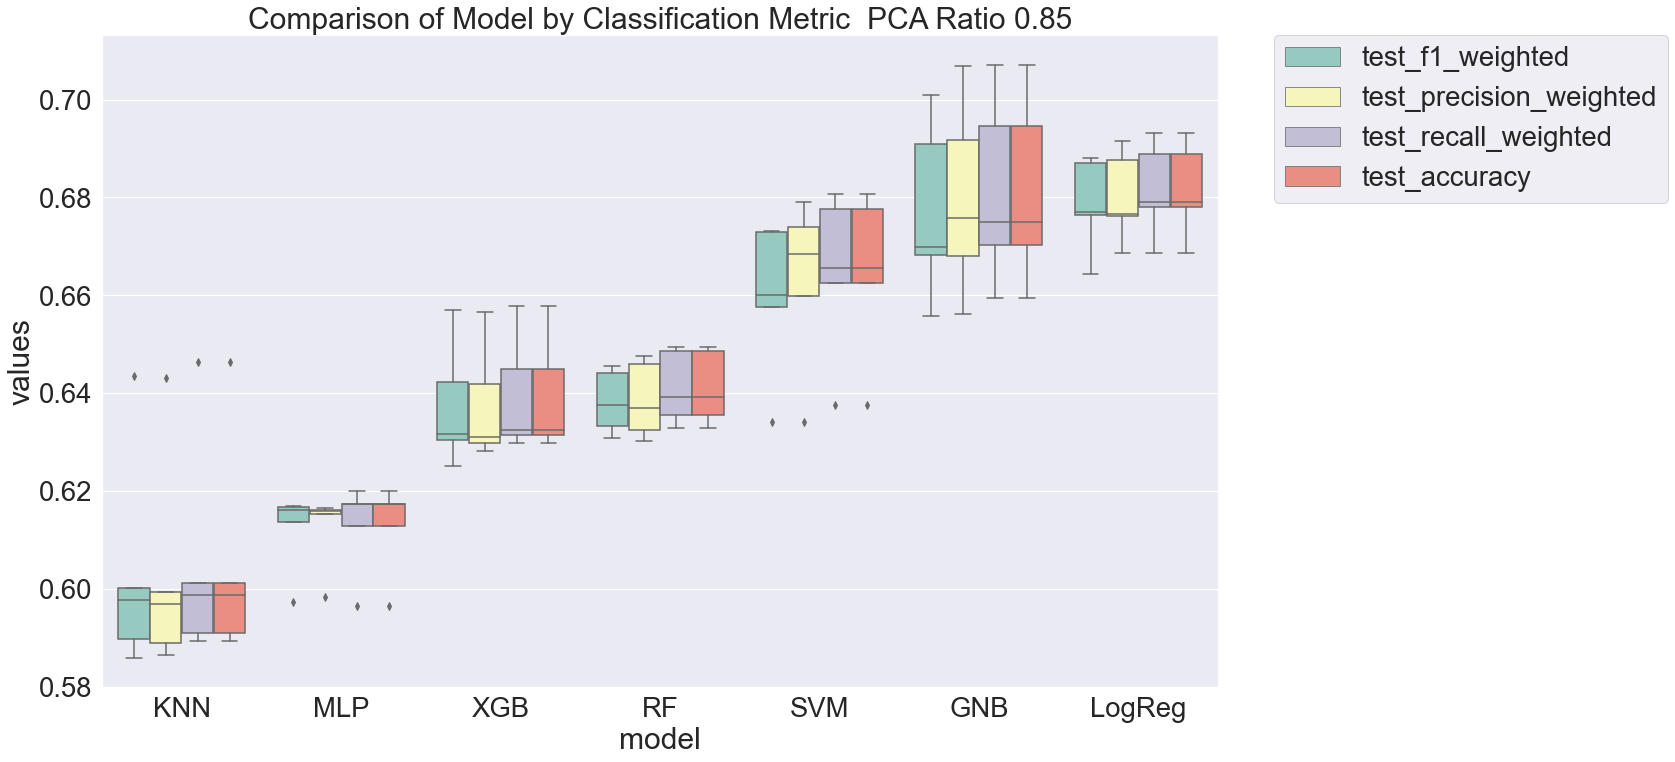

c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

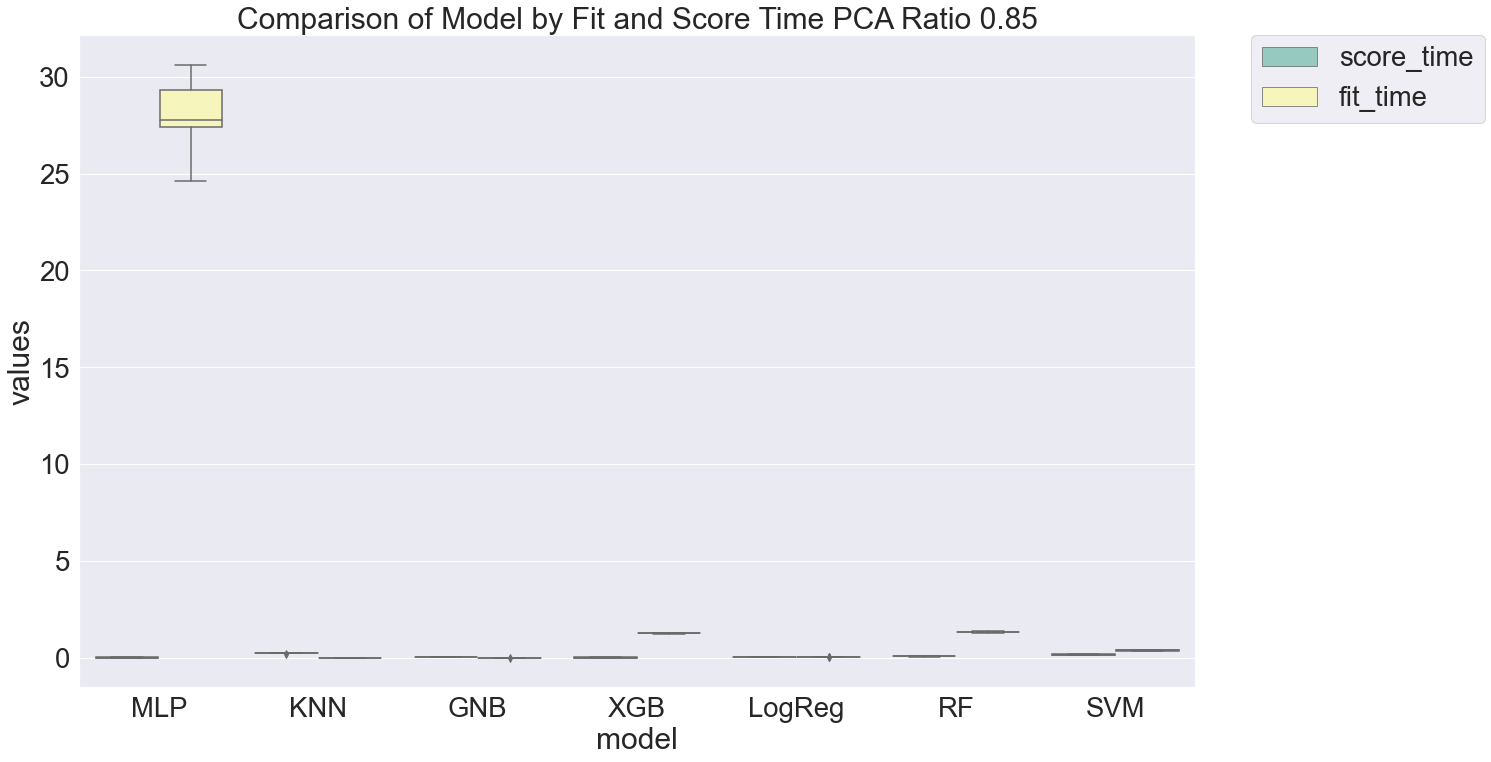

C:\Users\ethan\AppData\Local\Temp\ipykernel_29584\1381301588.py:17: FutureWarning: The provided callable <function std at 0x000001F37EB2F1F0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  df.groupby(['model'])[metrics].agg([np.std, np.mean])
C:\Users\ethan\AppData\Local\Temp\ipykernel_29584\1381301588.py:17: FutureWarning: The provided callable <function mean at 0x000001F37EB2F040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df.groupby(['model'])[metrics].agg([np.std, np.mean])
C:\Users\ethan\AppData\Local\Temp\ipykernel_29584\1381301588.py:17: FutureWarning: The provided callable <function std at 0x000001F37EB2F1F0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To ke

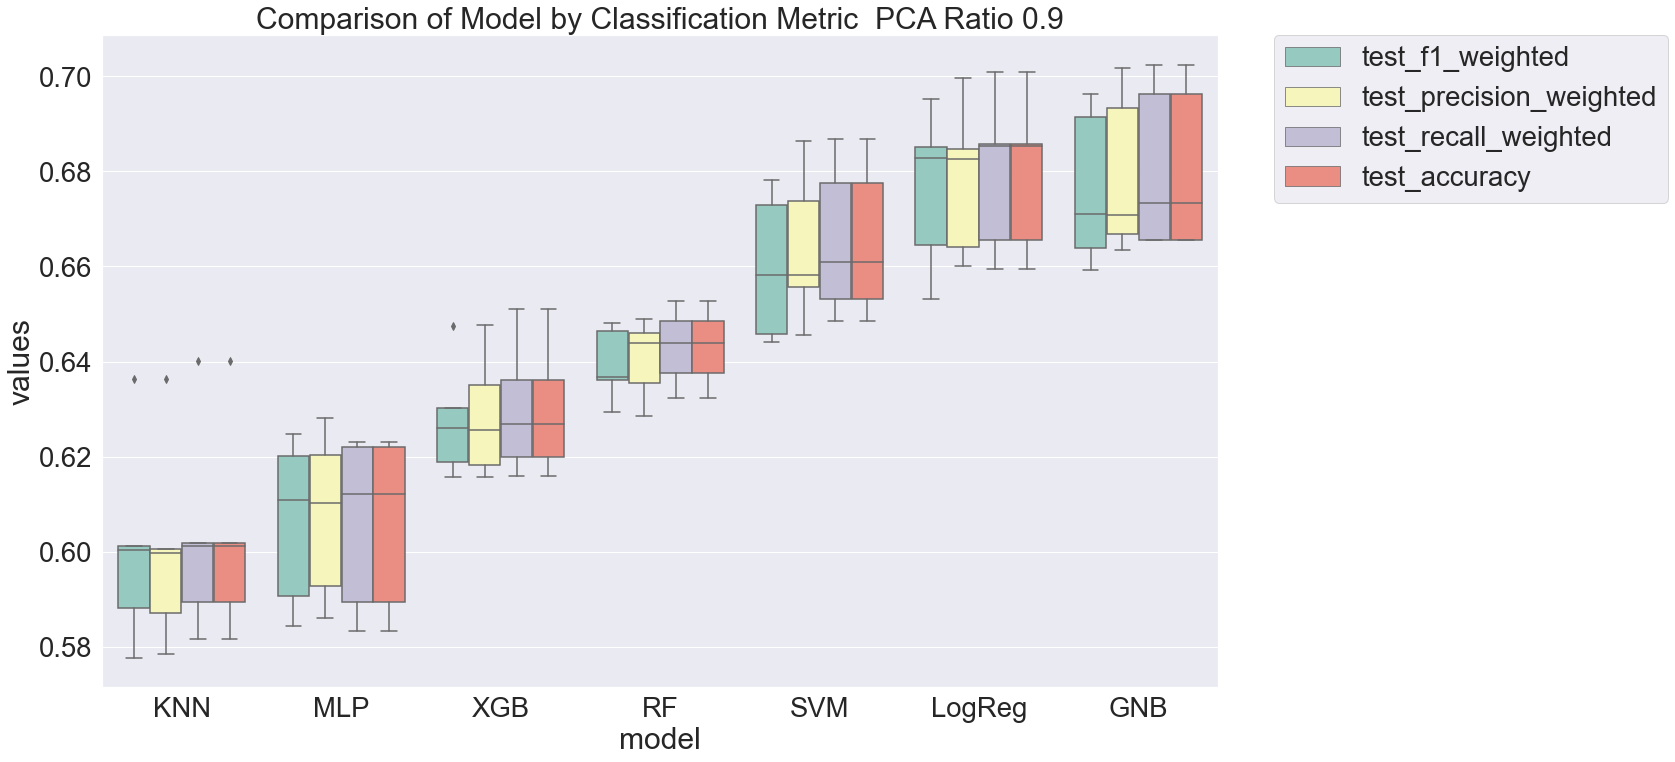

c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

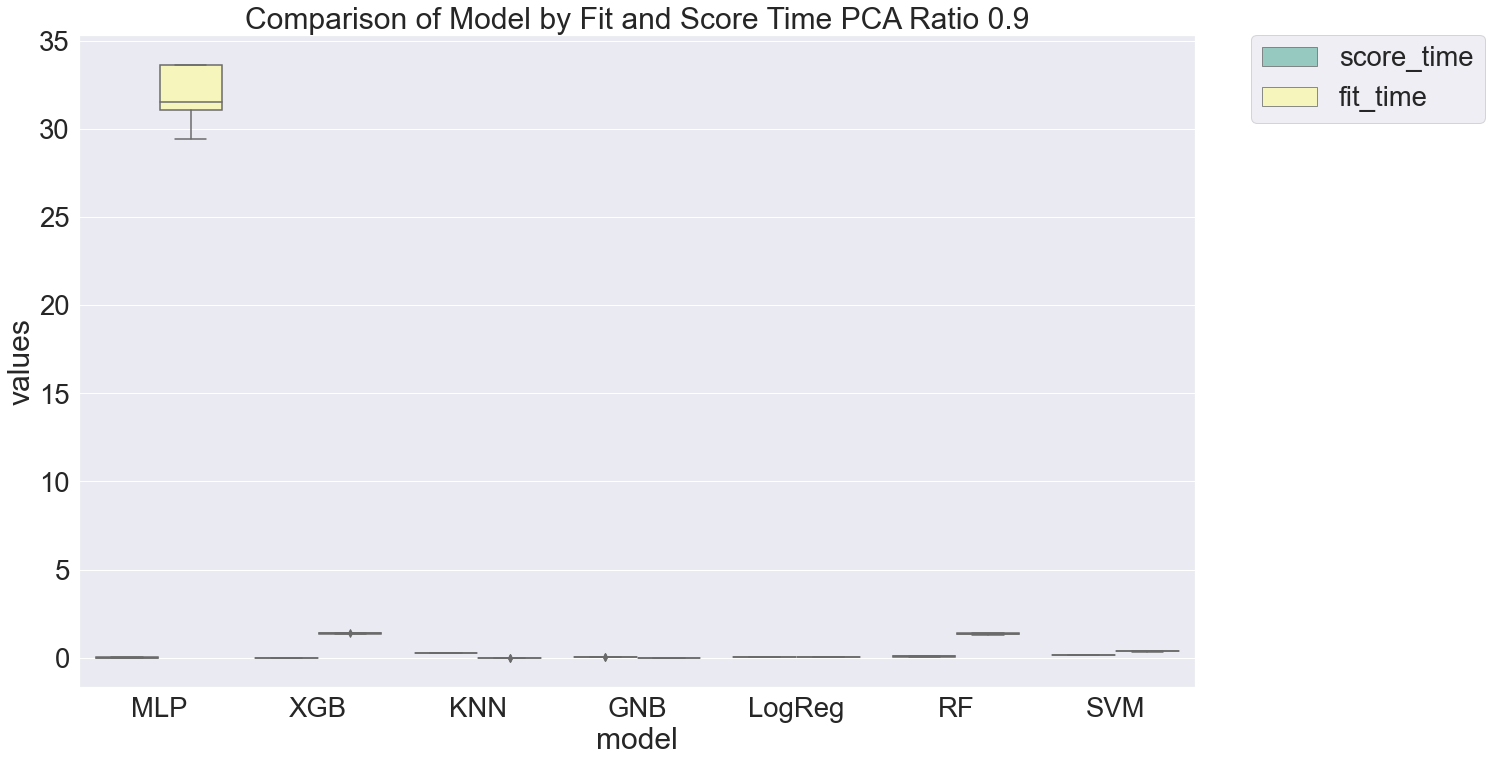

C:\Users\ethan\AppData\Local\Temp\ipykernel_29584\1381301588.py:17: FutureWarning: The provided callable <function std at 0x000001F37EB2F1F0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  df.groupby(['model'])[metrics].agg([np.std, np.mean])
C:\Users\ethan\AppData\Local\Temp\ipykernel_29584\1381301588.py:17: FutureWarning: The provided callable <function mean at 0x000001F37EB2F040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df.groupby(['model'])[metrics].agg([np.std, np.mean])
C:\Users\ethan\AppData\Local\Temp\ipykernel_29584\1381301588.py:17: FutureWarning: The provided callable <function std at 0x000001F37EB2F1F0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To ke

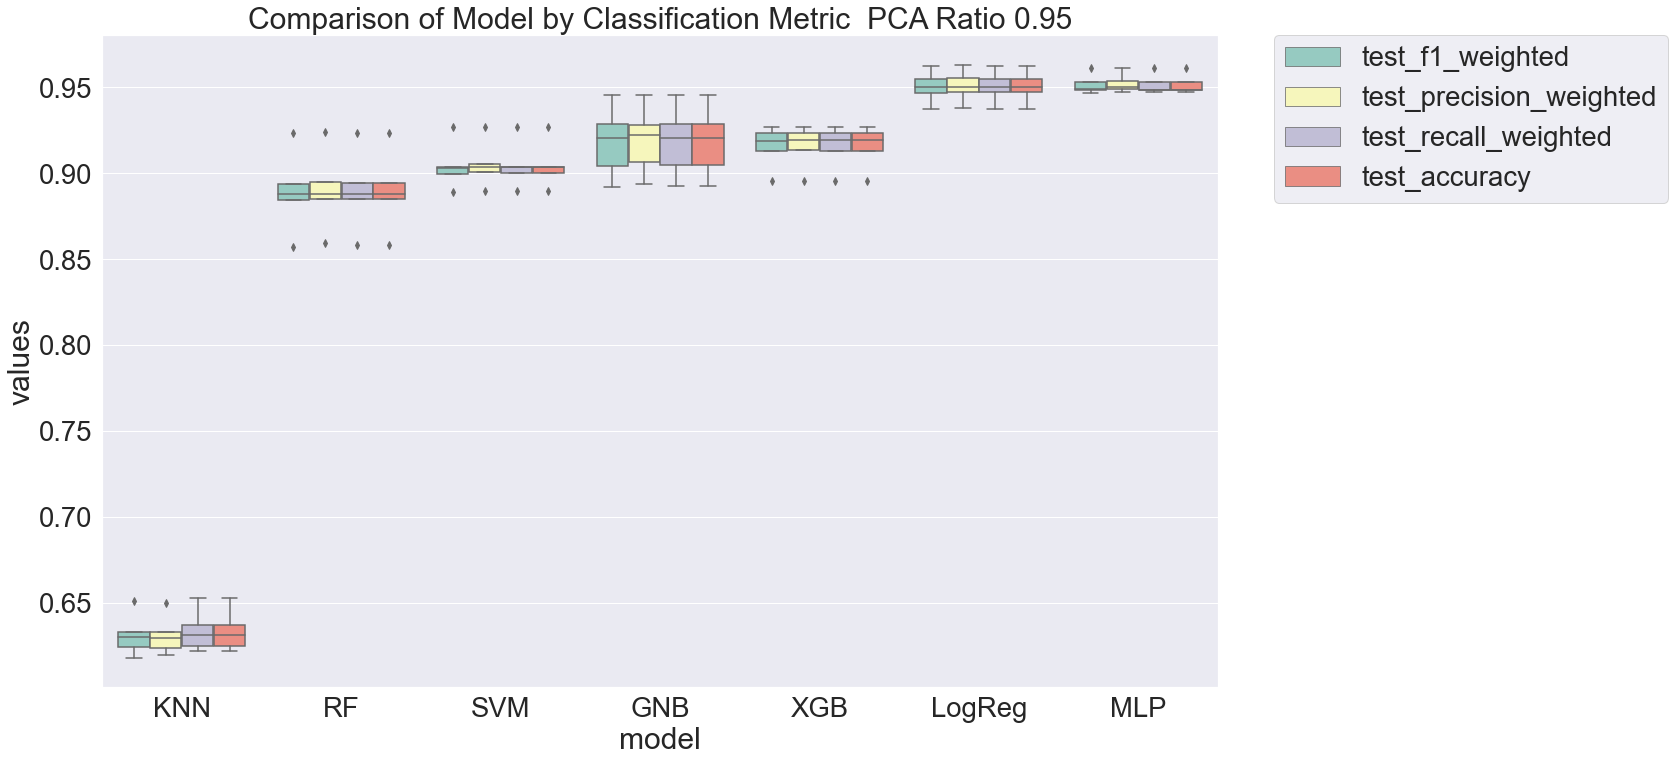

c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

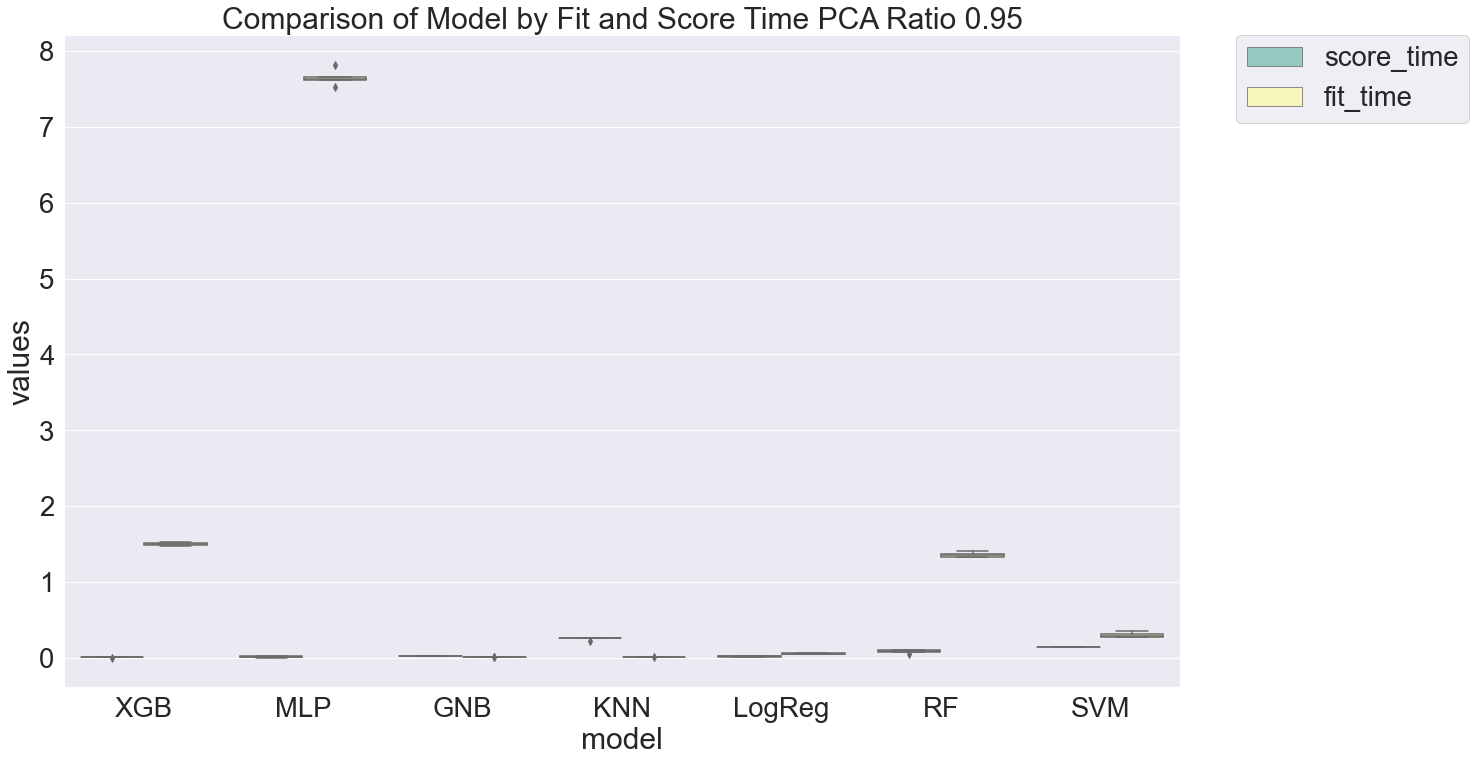

In [25]:
for i, (result, result2, pca_ratio_used) in enumerate(results):  
    results_long_nofit, results_long_fit = evaluate_models(result)
    n_features = result.shape[1] - len(['model', 'fit_time', 'score_time'])  
    generate_plots(n_features, pca_ratio_used, results_long_nofit, results_long_fit)